In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [43]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [22]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [23]:
inspector.get_table_names()

['measurement', 'station']

# Exploratory Climate Analysis

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspect_columns = inspector.get_columns('measurement')
for column in inspect_columns:
    print(column["name"], column["type"])
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
query_inspection = engine.execute('Select date, prcp FROM measurement').fetchall()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(query_inspection)
measurement_df = measurement_df.rename(columns={0: 'date', 1: 'precipitation'})
measurement_df['date'] = pd.to_datetime(measurement_df['date'], format='%Y-%m-%d')
measurement_df.head()

mask = (measurement_df['date'] > '2014-01-09') & (measurement_df['date'] <= '2015-01-09')
measurement_df_year = measurement_df.loc[mask]
measurement_df_year = measurement_df_year.set_index(['date'])

# Sort the dataframe by date
measurement_df_year.sort_index()
measurement_df_year.head()


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


,precipitation
date,
2014-01-10,NaN
2014-01-11,NaN
2014-01-12,0.35
2014-01-13,0.00
2014-01-14,0.43


![precipitation](Images/precipitation.png)

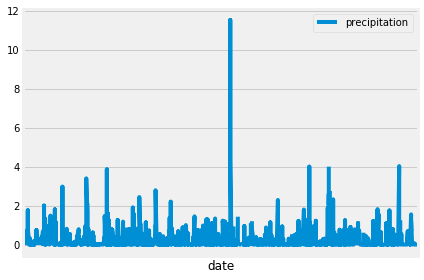

,precipitation
count,2406.000000
mean,0.176987
std,0.507208
min,0.000000
25%,0.000000
50%,0.020000
75%,0.140000
max,11.530000


In [40]:
# Use Pandas Plotting with Matplotlib to plot the data
measurement_df_year.plot()
plt.xticks([])
plt.tight_layout()
plt.show()

# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df_year.describe()

![describe](Images/describe.png)

In [41]:
# Design a query to show how many stations are available in this dataset?
station_query = engine.execute('SELECT COUNT(station) FROM station').fetchall()
station_count = station_query[0][0]

print(f'There are {station_count} stations in the data.')

There are 9 stations in the data.


In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
live_stations = [Measurement.station, func.count(Measurement.station)]
live_stations_query = session.query(*live_stations).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
live_stations_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

USC281_query = engine.execute('SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE station = "USC00519281"').fetchall()
USC281_stats = USC281_query[0]
USC281_stats

(54.0, 85.0, 71.66378066378067)

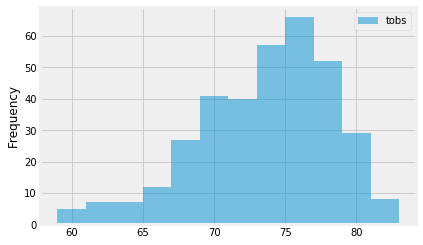

In [47]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC281_plotquery = engine.execute('SELECT date , tobs FROM measurement WHERE station = "USC00519281" AND date > "2016-08-23"').fetchall()
USC281_plotquery

usc281_df = pd.DataFrame(USC281_plotquery)
usc281_df = usc281_df.rename(columns={0: 'date', 1: 'tobs'})
usc281_df.head()

usc281_df.plot.hist(bins = 12, alpha=.5)

![precipitation](Images/station-histogram.png)

In [48]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2014-01-09', '2015-01-09'))

[(56.0, 73.15585412667946, 85.0)]


([<matplotlib.axis.YTick at 0x257f147c508>,
 <a list of 6 Text yticklabel objects>)

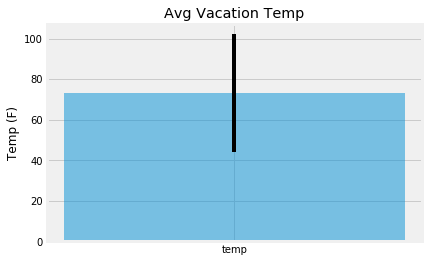

In [51]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
vacation_stats = calc_temps('2014-01-09', '2015-01-09')

vacay_yaxis = vacation_stats[0][1]
vacay_min = vacation_stats[0][0]
vacay_max = vacation_stats[0][2]
error = [vacay_max - vacay_min]

plt.bar("temp", vacay_yaxis, alpha=.5, align = "center", yerr = error, width=.01)
plt.title('Avg Vacation Temp')
plt.ylabel('Temp (F)')
plt.yticks(np.arange(0, 110, 20))

In [54]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prcptrip_query = engine.execute('SELECT measurement.station, name, latitude, longitude, elevation, AVG(prcp) FROM measurement \
LEFT JOIN station ON measurement.station = station.station \
WHERE date BETWEEN "2014-01-09" AND "2014-01-16" GROUP BY measurement.station ORDER BY AVG(prcp) DESC').fetchall()
prcptrip_query

[('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.41),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.33249999999999996),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.21),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.17833333333333334),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.1725),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.14375000000000002),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.14250000000000002),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.12625),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
